In [1]:
import numpy as np
import cvxpy as cp
import os
import sdpt3glue.solve as slv
from helper import hermitian, draw, awgn, toep

ModuleNotFoundError: No module named 'solve'

In [ ]:
doa = np.array( [ 20.0, 60.0 ] ) / 180 * np.pi # direction of arrival
N = 1 # number of samples
w = hermitian(np.array( [ np.pi / 4.0, np.pi / 3.0 ] )) # frequency
M = 10 # number of array elem
P = len(w) # number of signal
lam = 150.0 # wavelength
d = lam / 2 # elem spacing
snr = 20.0 # signal to noise ratio
# Assignment Matrix
D = np.zeros( (P, M), dtype=complex )
for k in range(P):
    D[k,:] = np.exp( -1j * 2 * np.pi * d * np.sin(doa[k]) / lam * np.array(range(M)) )
D = hermitian(D)
xx = np.zeros((P,N), dtype=complex)
for i, f in enumerate(w):
    xx[i,:] = np.array(2*np.exp( 1j * (f * (np.array(range(N)) + 1)))) # Simulate Signal
x = D @ xx
x += awgn(x,snr) # Insert Gaussian noise

#### Objective
$$\max{Re\langle x\cdot p \rangle}$$
#### Variables
$$p \in \mathbb{C}^{n}$$
$$H \in \mathbb{C}^{n\times n}$$
#### Constraints
$$\begin{bmatrix} H & p \\ p^{H} & 1 \end{bmatrix} \succeq 0$$
$$\sum_{i=1}^{n-k} {H_{i,i+k} = \delta_{k}}, k=0,\dots,n-1$$
$$\delta_{k} = \begin{cases} 1, & k=0 \\ 0, & k\neq 0 \end{cases}$$

In [ ]:
delta = lambda k : 1 if k == 0 else 0

def HpMatrix(H,p):
    return cp.bmat([
        [H   , p],
        [p.H , np.ones((1,1))]
    ])
    

# H = np.array([[1,2],[3,4]])
# print(summend(H,1))
n = M*N
H = cp.Variable((n,n), complex=True)
p = cp.Variable((n,1), complex=True)
## is semidefinite
constraints = [HpMatrix(H,p) >> 0]
constraints += [
    cp.sum([H[i][i+k] for i in range(n-k)]) == delta(k) for k in range(n)
]
prob = cp.Problem(cp.Maximize(cp.real(cp.scalar_product(x,p))),
                  constraints)
prob.solve()
print(H)
print(p)

var1
var2


In [ ]:
def ANM(X):
    RX = np.matmul(X,hermitian(X)) / N
    

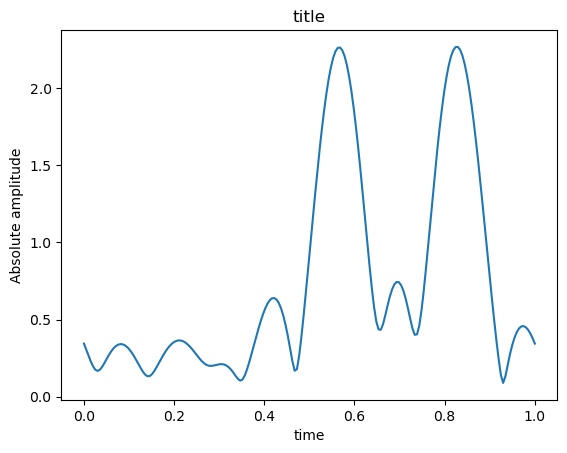

In [ ]:
# Assume no noise i.e. z=x+0
pVec = np.array(p.value)
t = np.linspace(0,1,200)
a = lambda tau : np.array([ np.exp(1j * 2* np.pi * kk * tau) for kk in range(n)])
A = np.array([ a(tau) for tau in t])
y = np.abs(A.dot(pVec))
draw(t, y, "time", "Absolute amplitude", "title")

c:\Users\alck2\anaconda3\envs\math4999\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


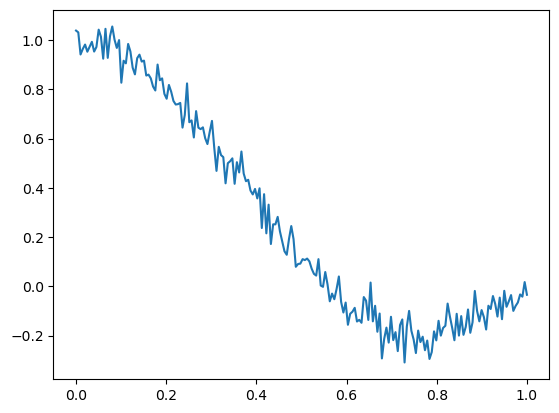

In [ ]:
N = 200
a = lambda theta : np.array([np.exp( 1j * 2 * np.pi * np.linspace(0,1,N) * theta )])
tuple_pair = [(0.5, 0.2), (0.5, 0.7)]
fx = np.linspace(0,1,N)
ls = np.array([(c_k * a(theta_k)).reshape(N) for (c_k, theta_k) in tuple_pair])
# for k in range(len(tuple_pair)):
#     draw(fx, ls[k],"","","")
x = np.sum(ls , axis=0)
x += awgn(x,snr)
draw(fx, x, "","","")


In [ ]:
delta = lambda k : 1 if k == 0 else 0

def HpMatrix(H,p):
    return cp.bmat([
        [H   , p],
        [p.H , np.ones((1,1))]
    ])
    

n = N
H = cp.Variable((n,n), complex=True)
p = cp.Variable((n,1), complex=True)
## is semidefinite
constraints = [HpMatrix(H,p) >> 0]
constraints += [
    cp.sum([H[i][i+k] for i in range(n-k)]) == delta(k) for k in range(n)
]


In [ ]:
def ANM(z, lamb, rho):
    # L = lambda x,u,t,Sigma,S: 0.5 * cp.norm(x-z) \
    #                         + lamb * 0.5 * (1/n * cp.trace(toep(u).value) + t) \
    #                         + cp.inner(Sigma, S - blockMatrix.value) + \
    #                         rho / 2 * cp.norm( S - blockMatrix.value, 'fro' ) ** 2
    j = 0
    Sigma = np.zeros((n+1,n+1))
    S = np.zeros((n+1,n+1))
    while (j < 100):
        x = cp.Variable((n,1), complex=True)
        u = cp.Variable((n,1), complex=True)
        t = cp.Variable((1,1))
        blockMatrix = cp.bmat([
            [ toep(u), x ],
            [ x.H,     t ]
        ])
        L1 = 0.5 * cp.norm(x-z) \
            + lamb * 0.5 * (1/n * cp.trace(toep(u)) + t) \
            + cp.trace( Sigma.conj().T @ S - blockMatrix) \
            + rho / 2 * cp.norm( S - blockMatrix, 'fro' ) ** 2
        prob1 = cp.Problem( cp.Minimize( cp.real(L1) ) )
        matfile_target = os.path.join('./extra', 'matfile.mat')  # Where to save the .mat file to
        output_target = os.path.join('./extra', 'output.txt')    # Where to save the output log
        prob1.solve()

        S = cp.Variable((n+1,n+1), complex=True)
        L2 = 0.5 * cp.norm(x.value-z) \
            + lamb * 0.5 * (1/n * cp.trace(toep(u.value).value) + t.value) \
            + cp.trace( Sigma.conj().T @ S - blockMatrix.value) \
            + rho / 2 * cp.norm( S - blockMatrix.value, 'fro' ) ** 2
        prob2 = cp.Problem( cp.Minimize( cp.real(L2) ), [ S >> 0 ] )
        prob2.solve()

        Sigma = Sigma + rho * ( S.value - blockMatrix.value )
        j += 1
    return x.value
ANM(x.reshape(x.shape[0],1), 0.8, 0.2)


c:\Users\alck2\anaconda3\envs\math4999\lib\site-packages\cvxpy\problems\problem.py:155: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
c:\Users\alck2\anaconda3\envs\math4999\lib\site-packages\cvxpy\problems\problem.py:161: UserWarning: Constraint #2 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


OverflowError: number of elements exceeds INT_MAX

In [ ]:
z = np.array([9,8,7])
lamb = 0.8
rho = 0.2
x = np.array([-1,-2,-3]).reshape(3,1)
u = np.array([1,2,3]).reshape(3,1)
t = np.array([1]).reshape(1,1)
print(toep(u).shape, x.shape, x.T.shape, t.shape)
blockMatrix = cp.bmat([
            [ toep(u), x ],
            [ x.T,     t ]
        ])
print(blockMatrix.value)
L = lambda x,u,t,Sigma,S: 0.5 * np.linalg.norm(x-z) \
                            + lamb * 0.5 * (1/n * np.trace(toep(u).value) + t) \
                            + np.inner(Sigma, S - blockMatrix.value) + \
                            rho / 2 * np.linalg.norm( S - blockMatrix.value, 'fro' ) ** 2

Sigma = np.zeros(3+1)
S = np.zeros(3+1)
L1 = L(x,u,t,Sigma,S)
print(L1)


(3, 3) (3, 1) (1, 3) (1, 1)
[[ 1.  2.  3. -1.]
 [ 2.  1.  2. -2.]
 [ 3.  2.  1. -3.]
 [-1. -2. -3.  1.]]
[[22.10566887 22.10566887 22.10566887 22.10566887]]
